# [Batch Normalization : Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167v3.pdf)

$$ \text{By Kent Chiu @ 20161115} $$

# Core Concept 

For me, the core concept is the **mapping ** & **difference.** 

First : Keep Difference is the thing that matters. 
Since the neuron network is just acting like the real neuron, the relative difference is the true thing that really matters. 

So basically, as long as we keep its relative difference, the neuron network could still works well. 

However, the actual amplitude, we could actually see it as the energy or voltage or whatever you like, just CPU nowadays could be drive in a lower votagle and doing the exactly same computation thing or even better in performance. 

The data in euron network is actually like the electricity-signal in our brain or in the CPU/GPU. 

Here the Author acchieve it with the most classic and most useful method ** Standardized **


Second, to keep the differece is actually must be depending on the dependency.
For example, the input data is actually keeping been operated by operations, layer by layer. 
The operation style is actually defining how we **Standardize** the data. 

If the operations are highly dependent, we just want to perform the data with same batch-normalize. 

On the other hand, if the operations itself is not highly dependent, then with each operation, we could do a batch-normalize.


# 核心思維

物質因為差異所以存在。訊息的傳遞的編碼與解碼也是一樣的。只要訊號存在差異，基本上我們就可以分辨。

因此大小的量度，其實意義不大。或者說，大小的定義，也是我們藉由一些測量或是交互或是操作，所得到具有差異的信息。

因此只要該操作群是相互獨立的，或是獨立性高的，那重點是在於保持差異，那訊息基本上是無損的。

但實際上，量度對物質有影響，因為量度也是透過其相依的測量/交互或操作所得到的。

道可道，非常道。但我們可以舉一些例子：

CPU的驅動電壓，從早期到現在基本上小了很多，但是這和處理的信息量其實是毫無相關的。

現在的ＣＰＵ並不因位驅動電壓減小了，而使得處理的信息量變小。

同理，我們腦中的神經元，處理的信息，其電壓更是微小。

數據對於類神經網路，其實就相當於電壓或是電流變化相當於真正的神經元一樣。

基本上，只要我們可以保持差異，那信息就不會丟失，只是對於物理量度來說，可能跨越不夠某些反應/交戶/操作，所需要的活化能，這其實是另一個量度世界的考量了。

作者採用了標準化，保持相對差異。

而保持差異因為存在，其實是依據(操作/交互/反應/量測)而定的。因為每一次(操作/交互/反應/量測)，就會產生新的量度。

Pr( Difference | Operation )

所以BN使用的方法時機，會根據操作不同 (conv 操作與 fully connect 操作)




# Expression in Math

$ \begin{array} \\
\text{Algorithm 1 : Batch Normalizing Transform, applied to activation x over a mini-batch. } \\  
\hline 
\text{Input : Values of x over a mini-Batch : } B \{  x_{1 \text{ ... m }} \} \text{ ; Parameters to be learned : } \beta \text{ and } \gamma \\
\text{Output : A set of } Y : \{ y_{i} = \text{ BatchNorm}_{\beta, \gamma}(x^{i}) \} \\
\text{ } \mu_{ \beta } \leftarrow  \frac{1}{m} \sum_{i=1}^m x_{i} \text{ --- Mini-batch mean}\\
\text{ } \mu_{ \beta } \leftarrow  \frac{1}{m} \sum_{i=1}^m (x_{i} - \mu_{\beta})^{2} \text{ --- Mini-batch variance}\\
\end{array} $


$ \mu_{ \beta } \leftarrow  \frac{1}{m} \sum_{i=1}^m x_{i} \text{ --- Mini-batch mean} $



# Expression in Code 


Transfer Learning 

- https://github.com/ry/tensorflow-vgg16


# Reference 

- https://github.com/pkmital/CADL/blob/master/session-4/libs/batch_norm.py

- http://cthorey.github.io./backpropagation/

- http://r2rt.com/implementing-batch-normalization-in-tensorflow.html

- https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

- https://www.zhihu.com/question/38102762

- http://shuokay.com/2016/10/15/wavenet/

- http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html

- http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow

In [3]:
import numpy as np
import tensorflow as tf
#from tensorflow.python import control_flow_ops

def batch_norm(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('/Users/kentchiu/deep_learning_research/data/MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /Users/kentchiu/deep_learning_research/data/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /Users/kentchiu/deep_learning_research/data/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /Users/kentchiu/deep_learning_research/data/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /Users/kentchiu/deep_learning_research/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [15]:
# Batch Normalization Forward

# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [16]:
# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)

# Note that pre-batch normalization bias is ommitted. The effect of this bias would be
# eliminated when subtracting the batch mean. Instead, the role of the bias is performed
# by the new beta variable. See Section 3.2 of the BN2015 paper.
z1_BN = tf.matmul(x,w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# Create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

In [17]:
# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

In [18]:
# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

In [19]:
# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

In [21]:
# Train the Network 

zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(40000):
    batch = mnist.train.next_batch(60)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],
          feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3],axis=0)) # record the mean value of BN2 over the entire test set
        print (".")

zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


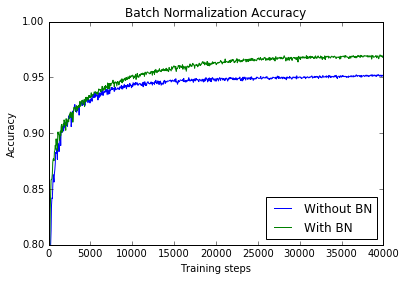

In [22]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [24]:
'''
Save and Restore a model using TensorFlow.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf

# Parameters
learning_rate = 0.001
batch_size = 100
display_step = 1
model_path = "/tmp/model.ckpt"

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# Running first session
print("Starting 1st session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Training cycle
    for epoch in range(3):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("First Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)

# Running a new session
print("Starting 2nd session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % save_path)

    # Resume training
    for epoch in range(7):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Second Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval(
        {x: mnist.test.images, y: mnist.test.labels}))

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Starting 1st session...
Epoch: 0001 cost= 164.709009379
Epoch: 0002 cost= 39.746273469
Epoch: 0003 cost= 24.618006897
First Optimization Finished!
Accuracy: 0.9129
Model saved in file: /tmp/model.ckpt
Starting 2nd session...
Model restored from file: /tmp/model.ckpt
Epoch: 0001 cost= 17.003537263
Epoch: 0002 cost= 12.180232949
Epoch: 0003 cost= 9.019476439
Epoch: 0004 cost= 6.707634071
Epoch: 0005 cost= 5.014267356
Epoch: 0006 cost= 3.689016492
Epoch: 0007 cost= 2.808352564
Second Optimization Finished!
Accuracy: 0.94


In [8]:

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, 20, 20, 10], name='input')
phase_train = tf.placeholder(tf.bool, name='phase_train')

# generate random noise to pass into batch norm
x_gen = tf.random_normal([50,20,20,10])
pt_false = tf.Variable(tf.constant(True))

#generate a constant variable to pass into batch norm
y = x_gen.eval()

[bn, bn_vars] = batch_norm(x, 10, phase_train)

tf.initialize_all_variables().run()
train_step = lambda: bn.eval({x:x_gen.eval(), phase_train:True})
test_step = lambda: bn.eval({x:y, phase_train:False})
test_step_c = lambda: bn.eval({x:y, phase_train:True})

# Verify that this is different as expected, two different x's have different norms
print(train_step()[0][0][0])
print(train_step()[0][0][0])

# Verify that this is same as expected, same x's (y) have same norm
print(train_step_c()[0][0][0])
print(train_step_c()[0][0][0])

# THIS IS DIFFERENT but should be they same, should only be reading from the ema.
print(test_step()[0][0][0])
print(test_step()[0][0][0])

TypeError: 'Output' object is not iterable.

In [5]:
import math

n_in, n_out = 3, 16
ksize = 3
stride = 1
phase_train = tf.placeholder(tf.bool, name='phase_train')
input_image = tf.placeholder(tf.float32, name='input_image')
kernel = tf.Variable(tf.truncated_normal([ksize, ksize, n_in, n_out],
                                   stddev=math.sqrt(2.0/(ksize*ksize*n_out))),
                                   name='kernel')
conv = tf.nn.conv2d(input_image, kernel, [1,stride,stride,1], padding='SAME')
conv_bn = batch_norm(conv, n_out, phase_train)
relu = tf.nn.relu(conv_bn)

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    for i in range(20):
        test_image = np.random.rand(4,32,32,3)
        sess_outputs = session.run([relu],
          {input_image.name: test_image, phase_train.name: True})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [3]:
from keras.engine import Layer, InputSpec
from keras import initializations, regularizers
from keras import backend as K


class BatchNormalization(Layer):
    '''Normalize the activations of the previous layer at each batch,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        epsilon: small float > 0. Fuzz parameter.
        mode: integer, 0, 1 or 2.
            - 0: feature-wise normalization.
                Each feature map in the input will
                be normalized separately. The axis on which
                to normalize is specified by the `axis` argument.
                Note that if the input is a 4D image tensor
                using Theano conventions (samples, channels, rows, cols)
                then you should set `axis` to `1` to normalize along
                the channels axis.
                During training we use per-batch statistics to normalize
                the data, and during testing we use running averages
                computed during the training phase.
            - 1: sample-wise normalization. This mode assumes a 2D input.
            - 2: feature-wise normalization, like mode 0, but
                using per-batch statistics to normalize the data during both
                testing and training.
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
            Note that the order of this list is [gamma, beta, mean, std]
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the gamma vector.
        beta_regularizer: instance of [WeightRegularizer](../regularizers.md),
            applied to the beta vector.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://jmlr.org/proceedings/papers/v37/ioffe15.pdf)
    '''
    def __init__(self, epsilon=1e-5, mode=0, axis=-1, momentum=0.99,
                 weights=None, beta_init='zero', gamma_init='one',
                 gamma_regularizer=None, beta_regularizer=None, **kwargs):
        self.supports_masking = True
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.epsilon = epsilon
        self.mode = mode
        self.axis = axis
        self.momentum = momentum
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.initial_weights = weights
        if self.mode == 0:
            self.uses_learning_phase = True
        super(BatchNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)

        self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        self.regularizers = []
        if self.gamma_regularizer:
            self.gamma_regularizer.set_param(self.gamma)
            self.regularizers.append(self.gamma_regularizer)

        if self.beta_regularizer:
            self.beta_regularizer.set_param(self.beta)
            self.regularizers.append(self.beta_regularizer)

        self.running_mean = K.zeros(shape,
                                    name='{}_running_mean'.format(self.name))
        self.running_std = K.ones(shape,
                                  name='{}_running_std'.format(self.name))
        self.non_trainable_weights = [self.running_mean, self.running_std]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        self.called_with = None

    def call(self, x, mask=None):
        if self.mode == 0 or self.mode == 2:
            assert self.built, 'Layer must be built before being called'
            input_shape = self.input_spec[0].shape

            reduction_axes = list(range(len(input_shape)))
            del reduction_axes[self.axis]
            broadcast_shape = [1] * len(input_shape)
            broadcast_shape[self.axis] = input_shape[self.axis]

            if self.mode == 2:
                x_normed, mean, std = K.normalize_batch_in_training(
                    x, self.gamma, self.beta, reduction_axes,
                    epsilon=self.epsilon)
            else:
                # mode 0
                if self.called_with not in {None, x}:
                    raise Exception('You are attempting to share a '
                                    'same `BatchNormalization` layer across '
                                    'different data flows. '
                                    'This is not possible. '
                                    'You should use `mode=2` in '
                                    '`BatchNormalization`, which has '
                                    'a similar behavior but is shareable '
                                    '(see docs for a description of '
                                    'the behavior).')
                self.called_with = x
                x_normed, mean, std = K.normalize_batch_in_training(
                    x, self.gamma, self.beta, reduction_axes,
                    epsilon=self.epsilon)

                self.updates = [K.moving_average_update(self.running_mean, mean, self.momentum),
                                K.moving_average_update(self.running_std, std, self.momentum)]

                if K.backend() == 'tensorflow' and sorted(reduction_axes) == range(K.ndim(x))[:-1]:
                    x_normed_running = K.batch_normalization(
                        x, self.running_mean, self.running_std,
                        self.beta, self.gamma,
                        epsilon=self.epsilon)
                else:
                    # need broadcasting
                    broadcast_running_mean = K.reshape(self.running_mean, broadcast_shape)
                    broadcast_running_std = K.reshape(self.running_std, broadcast_shape)
                    broadcast_beta = K.reshape(self.beta, broadcast_shape)
                    broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
                    x_normed_running = K.batch_normalization(
                        x, broadcast_running_mean, broadcast_running_std,
                        broadcast_beta, broadcast_gamma,
                        epsilon=self.epsilon)

                # pick the normalized form of x corresponding to the training phase
                x_normed = K.in_train_phase(x_normed, x_normed_running)

        elif self.mode == 1:
            # sample-wise normalization
            m = K.mean(x, axis=-1, keepdims=True)
            std = K.sqrt(K.var(x, axis=-1, keepdims=True) + self.epsilon)
            x_normed = (x - m) / (std + self.epsilon)
            x_normed = self.gamma * x_normed + self.beta
        return x_normed

    def get_config(self):
        config = {'epsilon': self.epsilon,
                  'mode': self.mode,
                  'axis': self.axis,
                  'gamma_regularizer': self.gamma_regularizer.get_config() if self.gamma_regularizer else None,
                  'beta_regularizer': self.beta_regularizer.get_config() if self.beta_regularizer else None,
                  'momentum': self.momentum}
        base_config = super(BatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [5]:
from IPython.core.display import HTML
HTML("""<style>
div.text_cell_render h1 {font-size: 2.4em;line-height:2.4em;text-align:left;}
div.text_cell_render h3 {font-size: 1.8em;line-height:1.8em;text-align:left;}
div.text_cell_render p {font-size: 1.4em;line-height:1.4em;text-align:left;}
div.text_cell_render li {font-size: 1.0em;line-height:1.0em;text-align:left;}
div.container pre{font-family: Monaco;font-size: 1.2em;line-height:1.2em;}
</style>""")

- [CS231 Youtube](https://www.youtube.com/watch?v=Vf_-OkqbwPo&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&index=12)

- 

In [41]:
import numpy as np

x = np.random.random(size=(10,30,30,3))
print (x.shape)

tf_x = tf.placeholder("float", [None, 30,30,3])

input1 = tf.placeholder(tf.float32) # place holder is not able to be eval
input2 = tf.Variable(x)
#output = tf.mul(input1, input2)


with tf.Session() as sess:
    
    sess.run(tf.initialize_all_variables())
    
    print (input2.eval())
    
    # Show in list or np array 
    x_ = sess.run([tf_x], feed_dict = { tf_x:x })
    print (x_ )


(10, 30, 30, 3)
[[[[ 0.89832491  0.74073259  0.69702154]
   [ 0.41813199  0.30042932  0.55091663]
   [ 0.17186376  0.71949197  0.75365476]
   ..., 
   [ 0.81863702  0.56082664  0.7038035 ]
   [ 0.40530724  0.94762405  0.66999269]
   [ 0.12545994  0.70678033  0.86147227]]

  [[ 0.47938645  0.66544564  0.02400668]
   [ 0.00351703  0.43009897  0.35642966]
   [ 0.87072869  0.64561302  0.33936732]
   ..., 
   [ 0.13518703  0.75539665  0.66291676]
   [ 0.24880344  0.7110323   0.20449154]
   [ 0.01424011  0.55126724  0.62524347]]

  [[ 0.24424882  0.45313095  0.58476978]
   [ 0.86441355  0.46237933  0.85738481]
   [ 0.70850982  0.87347843  0.68618125]
   ..., 
   [ 0.44556057  0.2104693   0.28916441]
   [ 0.61423935  0.39506338  0.10325649]
   [ 0.05635458  0.8378674   0.85790131]]

  ..., 
  [[ 0.35559305  0.2532878   0.23764048]
   [ 0.42841687  0.13936585  0.89868522]
   [ 0.78594937  0.38990995  0.67079933]
   ..., 
   [ 0.53712862  0.43112461  0.44864514]
   [ 0.08828806  0.92606751  0.2